In [1]:
# Import dependencies
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pathlib
import PIL
import PIL.Image
import cv2
from tqdm import tqdm

In [2]:
# Lets check your GPU
if tf.config.list_logical_devices('GPU') != []:
    print("LET'S DO THISS!!! :DDDD")
else: 
    print("Oh dude... D:")

LET'S DO THISS!!! :DDDD


### Dataset images

You can find dataset images celeba in here: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

Download it, and create a directory called "./img_align_celeba", save all images right there. 

In [3]:
'''

Lets define some dir to save iamges.

'''

from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
path = "./img_align_celeba"
data_dir = pathlib.Path(path)

# Lets check quantity
image_count = len(list(data_dir.glob('*.jpg')))
print('We have', image_count, 'images.')

We have 202599 images.


In [5]:
# Get all paths
all_paths = [str(x) for x in list(data_dir.glob('*.jpg'))]

In [6]:
train_path = all_paths[:int(image_count * 0.8)]
val_path = all_paths[int(image_count * 0.8): int(image_count * 0.9)]
test_path = all_paths[int(image_count * 0.9):]

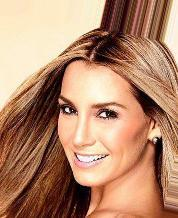

In [7]:
# Sanity check!
PIL.Image.open(train_path[0])

In [8]:
# Instanciate tf datasets
ds_train_path = tf.data.Dataset.from_tensor_slices(train_path)
ds_val_path = tf.data.Dataset.from_tensor_slices(val_path)
ds_test_path = tf.data.Dataset.from_tensor_slices(test_path)

In [9]:
'''

Open all images and resize.

'''

def open_image(x):
    return tf.ensure_shape(tf.image.decode_image(tf.io.read_file(x)), [218, 178, 3])

def resize_image(x, n_outputs=2):
    if n_outputs == 2:
        return (tf.image.resize(x, [128, 128]) / 255., tf.image.resize(x, [128, 128]) / 255.)
    return tf.image.resize(x, [128, 128]) / 255.

ds_train = ds_train_path.map(
    lambda x: resize_image(open_image(x))
)

ds_val = ds_val_path.map(
    lambda x: resize_image(open_image(x))
)

ds_test = ds_test_path.map(
    lambda x: resize_image(open_image(x))
)

## Load pre-trained model

In [12]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

In [13]:
custom_objects = {'Sampling': Sampling}

In [14]:
'''

Pre-trained models - Instructions about training you can find in another file

'''

variational_ae = keras.models.load_model('./regular_celeba_vae/autoencoder/vae_autoencoder.keras', custom_objects=custom_objects)
variational_encoder = keras.models.load_model('./regular_celeba_vae/encoder/vae_encoder.keras', custom_objects=custom_objects)
variational_decoder = keras.models.load_model('./regular_celeba_vae/decoder/vae_decoder.keras', custom_objects=custom_objects)

In [13]:
'''

Slice ds_train in batches

'''


dataset_train = ds_train.batch(128, drop_remainder=True).prefetch(1)
dataset_val = ds_val.batch(128, drop_remainder=True).prefetch(1)

In [14]:
for j in dataset_train.take(1):
    print(j[1].shape)

(128, 128, 128, 3)


In [15]:
'''

Define util functions to show images.

'''

from IPython.display import clear_output

def plot_multiple_images_without_k(images, n_cols=None, output_neural=False):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        
        if output_neural:
            plt.imshow(image, cmap="binary")
            clear_output()
        else:
            plt.imshow(image, cmap="binary")
        plt.axis("off")

def plot_multiple_images(images, n_cols=None, k=1):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols * k, n_rows * k))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        clear_output()
        plt.axis("off")
        
def plot_image(image, title=None):
    if title:
        plt.title(title, size=16)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

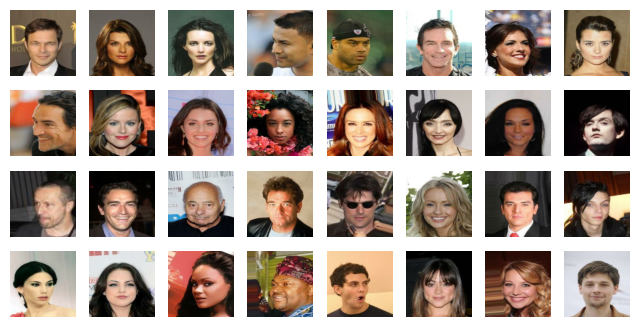

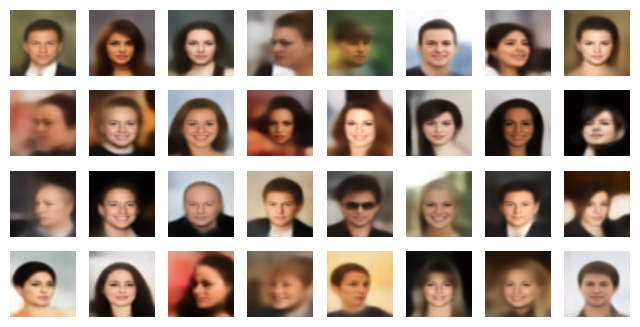

In [16]:
'''

Let's check sanity with models.

'''

for X_ds in dataset_train.take(1):
    plot_multiple_images_without_k(X_ds[0][32:64], 8)
    plot_multiple_images_without_k(variational_ae(X_ds[0][32:64]), 8, output_neural=True)

## Get Features from csv

In [17]:
df = pd.read_csv('./data/list_attr_celeba.csv')

In [19]:
df.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [55]:
for column in ['Bald', 'Smiling', 'Mustache', 'Eyeglasses', 'Goatee', 'Arched_Eyebrows', 'Bags_Under_Eyes']:
    print('--------------------')
    print(df[column].value_counts())
    print('--------------------')

--------------------
-1    198052
 1      4547
Name: Bald, dtype: int64
--------------------
--------------------
-1    104930
 1     97669
Name: Smiling, dtype: int64
--------------------
--------------------
-1    194182
 1      8417
Name: Mustache, dtype: int64
--------------------
--------------------
-1    189406
 1     13193
Name: Eyeglasses, dtype: int64
--------------------
--------------------
-1    189883
 1     12716
Name: Goatee, dtype: int64
--------------------
--------------------
-1    148509
 1     54090
Name: Arched_Eyebrows, dtype: int64
--------------------
--------------------
-1    161153
 1     41446
Name: Bags_Under_Eyes, dtype: int64
--------------------


In [22]:
df.head(2)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1


In [23]:
df['path'] = df['image_id'].apply(lambda x: 'img_align_celeba' + '\\' + x)

In [24]:
len(df[df['Bald'] == 1]['path'].values), len(df[df['Smiling'] == 1]['path'].values)

(4547, 97669)

In [86]:
df[(df['Bald'] == -1) & 
   (df['Smiling'] == -1) & 
   (df['Mustache'] == -1) & 
   (df['Eyeglasses'] == -1) & 
   (df['Goatee'] == -1) & 
   (df['Arched_Eyebrows'] == -1) & 
   (df['Bags_Under_Eyes'] == -1) & 
   (df['Male'] == 1) ]['path']

2         img_align_celeba\000003.jpg
36        img_align_celeba\000037.jpg
47        img_align_celeba\000048.jpg
48        img_align_celeba\000049.jpg
54        img_align_celeba\000055.jpg
                     ...             
202537    img_align_celeba\202538.jpg
202564    img_align_celeba\202565.jpg
202565    img_align_celeba\202566.jpg
202566    img_align_celeba\202567.jpg
202584    img_align_celeba\202585.jpg
Name: path, Length: 23553, dtype: object

In [88]:
Personas_Default = tf.data.Dataset.from_tensor_slices(  df[(df['Bald'] == -1) & 
                                                        (df['Smiling'] == -1) & 
                                                        (df['Mustache'] == -1) & 
                                                        (df['Eyeglasses'] == -1) & 
                                                        (df['Goatee'] == -1) & 
                                                        (df['Arched_Eyebrows'] == -1) & 
                                                        (df['Bags_Under_Eyes'] == -1) & 
                                                        (df['Male'] == 1) ]['path'].values[:10])

In [25]:
Bald_att_1 = tf.data.Dataset.from_tensor_slices(df[df['Bald'] ==  1]['path'].values[:5000])
Bald_att_0 = tf.data.Dataset.from_tensor_slices(df[(df['Bald'] == -1) & (df['Male'] == 1)]['path'].values[:5000])

In [26]:

Smiling_att_1 = tf.data.Dataset.from_tensor_slices(df[df['Smiling'] ==  1]['path'].values[:20000])
Smiling_att_0 = tf.data.Dataset.from_tensor_slices(df[df['Smiling'] ==  -1]['path'].values[:20000])

In [27]:
Mustache_att_1 = tf.data.Dataset.from_tensor_slices(df[df['Mustache'] ==  1]['path'].values[:8000])
Mustache_att_0 = tf.data.Dataset.from_tensor_slices(df[df['Mustache'] ==  -1]['path'].values[:8000])

In [80]:
EyeGlasses_att_1 = tf.data.Dataset.from_tensor_slices(df[(df['Eyeglasses'] ==  1) & (df['Bald'] == -1)]['path'].values[:50000])
EyeGlasses_att_0 = tf.data.Dataset.from_tensor_slices(df[df['Eyeglasses'] ==  -1]['path'].values[:50000])


In [56]:
Goatee_att_1 = tf.data.Dataset.from_tensor_slices(df[df['Goatee'] ==  1]['path'].values[:12000])
Goatee_att_0 = tf.data.Dataset.from_tensor_slices(df[df['Goatee'] ==  -1]['path'].values[:12000])

In [57]:
Arched_Eyebrows_att_1 = tf.data.Dataset.from_tensor_slices(df[df['Arched_Eyebrows'] ==  1]['path'].values[:20000])
Arched_Eyebrows_att_0 = tf.data.Dataset.from_tensor_slices(df[df['Arched_Eyebrows'] ==  -1]['path'].values[:20000])

In [58]:
Bags_Under_Eyes_att_1 = tf.data.Dataset.from_tensor_slices(df[df['Bags_Under_Eyes'] ==  1]['path'].values[:20000])
Bags_Under_Eyes_att_0 = tf.data.Dataset.from_tensor_slices(df[df['Bags_Under_Eyes'] ==  -1]['path'].values[:20000])

In [89]:
'''

We will here slice 2 subsets of all dataset and let's arrange in some class, in our case, we will use Bald feature.

'''


def open_image(x):
    return tf.ensure_shape(tf.image.decode_image(tf.io.read_file(x)), [218, 178, 3])

def resize_image(x, n_outputs=2):
    if n_outputs == 2:
        return (tf.image.resize(x, [128, 128]) / 255., tf.image.resize(x, [128, 128]) / 255.)
    elif n_outputs == 1:
        return tf.image.resize(x, [128, 128]) / 255.
    return 


ds_Personas_Default = Personas_Default.map(
    lambda x: resize_image(open_image(x))
)

ds_Bald_att_1 = Bald_att_1.map(
    lambda x: resize_image(open_image(x))
)

ds_Bald_att_0 = Bald_att_0.map(
    lambda x: resize_image(open_image(x))
)

ds_Smiling_att_1 = Smiling_att_1.map(
    lambda x: resize_image(open_image(x))
)

ds_Smiling_att_0 = Smiling_att_0.map(
    lambda x: resize_image(open_image(x))
)

ds_Mustache_att_1 = Mustache_att_1.map(
    lambda x: resize_image(open_image(x))
)

ds_Mustache_att_0 = Mustache_att_0.map(
    lambda x: resize_image(open_image(x))
)

ds_EyeGlasses_att_1 = EyeGlasses_att_1.map(
    lambda x: resize_image(open_image(x))
)

ds_EyeGlasses_att_0 = EyeGlasses_att_0.map(
    lambda x: resize_image(open_image(x))
)

ds_Goatee_att_1 = Goatee_att_1.map(
    lambda x: resize_image(open_image(x))
)

ds_Goatee_att_0 = Goatee_att_0.map(
    lambda x: resize_image(open_image(x))
)

ds_Arched_Eyebrows_att_1 = Arched_Eyebrows_att_1.map(
    lambda x: resize_image(open_image(x))
)

ds_Arched_Eyebrows_att_0 = Arched_Eyebrows_att_0.map(
    lambda x: resize_image(open_image(x))
)

ds_Bags_Under_Eyes_att_1 = Bags_Under_Eyes_att_1.map(
    lambda x: resize_image(open_image(x))
)

ds_Bags_Under_Eyes_att_0 = Bags_Under_Eyes_att_0.map(
    lambda x: resize_image(open_image(x))
)


In [92]:
_, _, codings_persona_default = variational_encoder.predict(ds_Personas_Default.batch(10, drop_remainder=True).prefetch(1))

1/1 [==============================] - 0s 285ms/step


In [82]:
_, _, codings_att4_1 = variational_encoder.predict(ds_EyeGlasses_att_1.batch(32).prefetch(1))
_, _, codings_att4_0 = variational_encoder.predict(ds_EyeGlasses_att_0.batch(32).prefetch(1))

1563/1563 [==============================] - 38s 24ms/step


In [61]:
'''

Let's encode all images!

'''

_, _, codings_persona_default = variational_encoder.predict(ds_Personas_Default.batch(10, drop_remainder=True).prefetch(1))

_, _, codings_att1_1 = variational_encoder.predict(ds_Bald_att_1.batch(32).prefetch(1))
_, _, codings_att1_0 = variational_encoder.predict(ds_Bald_att_0.batch(32).prefetch(1))

_, _, codings_att2_1 = variational_encoder.predict(ds_Smiling_att_1.batch(32).prefetch(1))
_, _, codings_att2_0 = variational_encoder.predict(ds_Smiling_att_0.batch(32).prefetch(1))

_, _, codings_att3_1 = variational_encoder.predict(ds_Mustache_att_1.batch(32).prefetch(1))
_, _, codings_att3_0 = variational_encoder.predict(ds_Mustache_att_0.batch(32).prefetch(1))

_, _, codings_att4_1 = variational_encoder.predict(ds_EyeGlasses_att_1.batch(32).prefetch(1))
_, _, codings_att4_0 = variational_encoder.predict(ds_EyeGlasses_att_0.batch(32).prefetch(1))

_, _, codings_att5_1 = variational_encoder.predict(ds_Goatee_att_1.batch(32).prefetch(1))
_, _, codings_att5_0 = variational_encoder.predict(ds_Goatee_att_0.batch(32).prefetch(1))

_, _, codings_att6_1 = variational_encoder.predict(ds_Arched_Eyebrows_att_1.batch(32).prefetch(1))
_, _, codings_att6_0 = variational_encoder.predict(ds_Arched_Eyebrows_att_0.batch(32).prefetch(1))

_, _, codings_att7_1 = variational_encoder.predict(ds_Bags_Under_Eyes_att_1.batch(32).prefetch(1))
_, _, codings_att7_0 = variational_encoder.predict(ds_Bags_Under_Eyes_att_0.batch(32).prefetch(1))


625/625 [==============================] - 17s 27ms/step


In [31]:
codings_att1_1.shape, codings_att1_0.shape

((4547, 64), (5000, 64))

In [32]:
codings_att2_1.shape, codings_att2_0.shape

((20000, 64), (20000, 64))

In [33]:
all_codings_att1 = np.concatenate((codings_att1_1, codings_att1_0), axis=0)
all_codings_att2 = np.concatenate((codings_att2_1, codings_att2_0), axis=0)
all_codings_att3 = np.concatenate((codings_att3_1, codings_att3_0), axis=0)
all_codings_att4 = np.concatenate((codings_att4_1, codings_att4_0), axis=0)

In [83]:
v_att1 = tf.reduce_mean(codings_att1_1, axis=0) - tf.reduce_mean(codings_att1_0, axis=0)
v_att2 = tf.reduce_mean(codings_att2_1, axis=0) - tf.reduce_mean(codings_att2_0, axis=0)
v_att3 = tf.reduce_mean(codings_att3_1, axis=0) - tf.reduce_mean(codings_att3_0, axis=0)
v_att4 = tf.reduce_mean(codings_att4_1, axis=0) - tf.reduce_mean(codings_att4_0, axis=0)
v_att5 = tf.reduce_mean(codings_att5_1, axis=0) - tf.reduce_mean(codings_att5_0, axis=0)
v_att6 = tf.reduce_mean(codings_att6_1, axis=0) - tf.reduce_mean(codings_att6_0, axis=0)
v_att7 = tf.reduce_mean(codings_att7_1, axis=0) - tf.reduce_mean(codings_att7_0, axis=0)

In [35]:
def plot_multiple_images_tag(images, n_cols=None, k=1, tag=False, ts=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols * k, n_rows * k))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        
        clear_output()
        if tag and ts:
            plt.title(f'Reconstructed: {tag}, t={ts[index]}')
        elif tag and not ts:
            plt.title(f'Reconstructed: {tag}')
        plt.axis("off")

In [36]:
i = 43
delta = 1
k = 4
t = 0.8
fake_imgs = []
ts = [0.2, 0.5, 0.8, 1.1, 1.4, 1.7]
for t in ts:
    fake_imgs.append((codings_att1_0[i:i + delta] + t * v_att1)[0])
fake_imgs = tf.convert_to_tensor(np.array(fake_imgs))

original_imgs = []
for t in ts:
    original_imgs.append((codings_att1_0[i:i + delta] + 0.0 * v_att1)[0])
original_imgs = tf.convert_to_tensor(np.array(original_imgs))

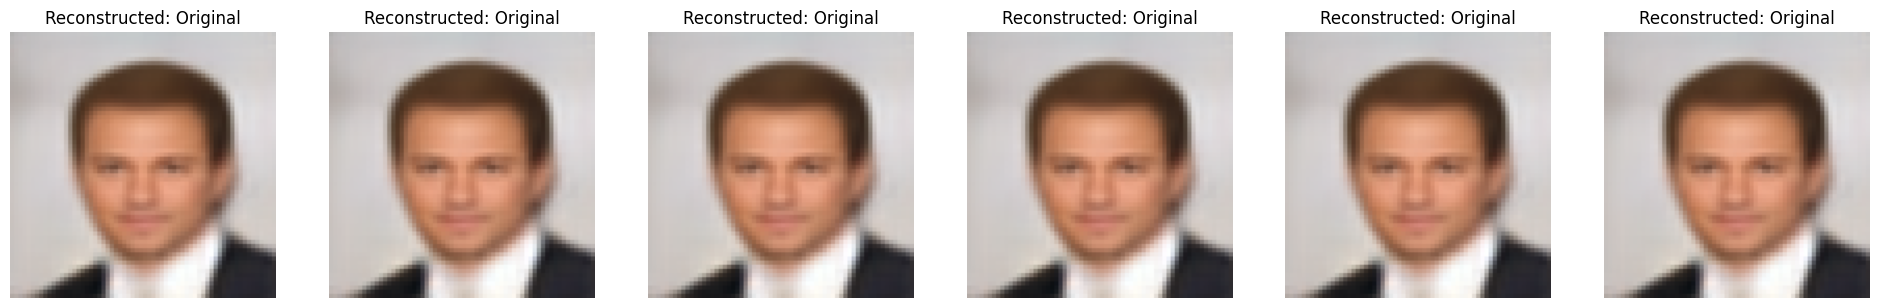

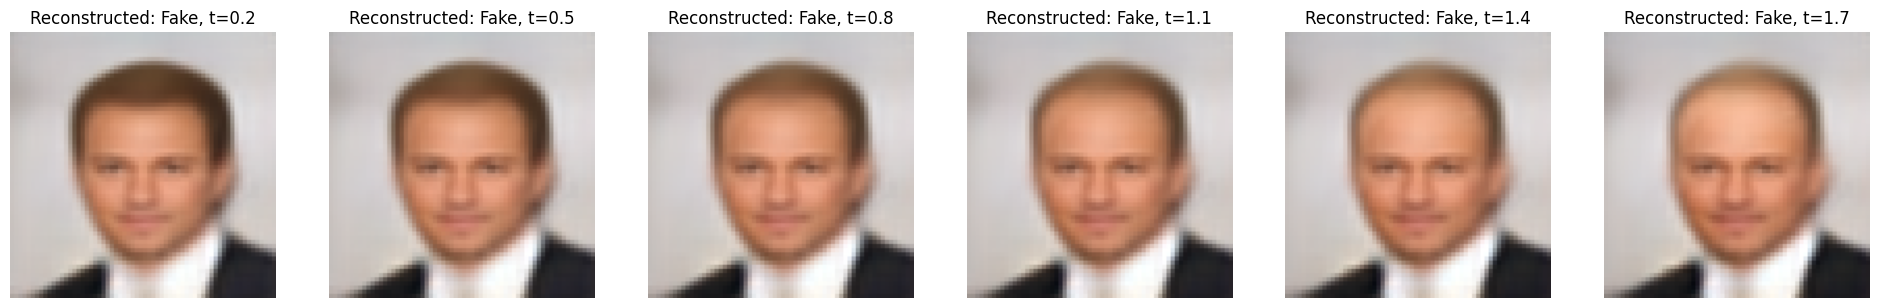

In [45]:
idx = 0
for X_ds in ds_Bald_att_0.batch(20).prefetch(1).take(1):
    plot_multiple_images_tag(variational_decoder(original_imgs), len(ts), k=k, tag='Original')
    plot_multiple_images_tag(variational_decoder(fake_imgs), len(ts), k=k, tag='Fake', ts=ts)
    idx += 1

In [74]:
df_atts = pd.concat([pd.DataFrame(v_att1.numpy()).T, 
                     pd.DataFrame(v_att2.numpy()).T,
                     pd.DataFrame(v_att3.numpy()).T,
                     pd.DataFrame(v_att4.numpy()).T,
                     pd.DataFrame(v_att5.numpy()).T,
                     pd.DataFrame(v_att6.numpy()).T,
                     pd.DataFrame(v_att7.numpy()).T,], axis=0).set_index(pd.Index(['Bald', 'Smiling', 'Mustache', 'Eyeglasses', 'Goatee', 'Arched_Eyebrows', 'Bags_Under_Eyes']))

In [75]:
df_atts

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
Bald,0.254300,0.083487,-0.153665,-0.136455,-0.095869,-0.013854,-0.029685,0.152194,0.304285,0.072775,...,0.013333,0.031215,-0.051423,0.175043,0.084519,-0.229313,-0.374857,0.160002,-0.089996,-0.076332
Smiling,-0.051176,-0.611933,-0.268578,-0.088951,-0.143955,-0.114988,0.043636,-0.068504,0.319384,0.060691,...,-0.350781,0.107341,-0.078959,-0.025522,0.105463,-0.105471,-0.037527,-0.095952,-0.102460,-0.095045
Mustache,-0.051678,0.293364,0.024703,0.032957,0.084550,-0.062044,-0.002594,0.043746,-0.157436,-0.029289,...,0.278024,-0.158213,-0.156596,-0.108128,0.058892,0.256500,0.072598,0.026758,0.059487,-0.149393
Eyeglasses,0.137430,0.089743,-0.259120,0.239939,-0.445188,0.023072,0.056013,-0.033486,0.424953,-0.001121,...,0.107418,-0.061692,-0.115348,0.070788,0.142873,0.222679,-0.111543,-0.006904,-0.313891,0.005132
Goatee,-0.012149,0.272767,0.035261,0.006421,0.138851,-0.033328,0.022864,0.052492,-0.184222,-0.026372,...,0.312922,-0.134652,-0.200657,-0.174020,0.048959,0.239251,0.048939,0.020419,0.099405,-0.143030
Arched_Eyebrows,-0.187612,-0.109859,0.002414,-0.028372,-0.043847,-0.036915,0.017008,-0.038298,-0.049344,0.062129,...,-0.166115,0.086047,-0.016271,-0.063421,-0.048647,-0.272670,-0.088343,-0.031059,-0.042971,0.007833
Bags_Under_Eyes,0.065925,-0.075293,-0.070102,-0.004655,0.017193,-0.041261,0.028618,0.039692,-0.004812,-0.015004,...,0.204793,-0.039316,-0.030054,-0.121292,0.090275,0.131722,0.007037,0.004479,0.044087,-0.037385


In [76]:
df_atts.to_csv('./data/attributes_encodings.csv')

In [40]:
df_example_instance = pd.DataFrame(codings_att1_0[i:i + delta]).set_index(pd.Index(['Original']))

In [95]:
df_example_instance

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
Original,0.379235,0.5543,1.937188,0.23338,-0.288102,0.569891,2.188432,-0.053124,-0.096966,1.426203,...,-0.131359,0.762879,0.277864,1.165162,-1.243862,0.84066,1.541582,-0.658806,1.242943,-1.87495


In [99]:
df_example_instances = pd.concat([df_example_instance, pd.DataFrame(codings_persona_default)])

In [100]:
df_example_instances.to_csv('./data/example_instances.csv')

In [74]:
df_example_instance.to_csv('./data/example_instance.csv')

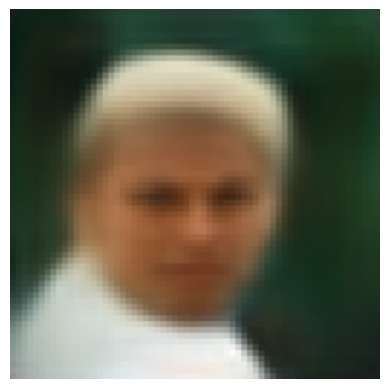

In [109]:
plot_image(variational_decoder(codings_persona_default[7:8])[0])

## Load data

In [3]:
df_atts_loaded = pd.read_csv('./data/attributes_encodings.csv', index_col=0)
df_atts_loaded.values[0], df_atts_loaded.values[1], df_atts_loaded.values[2], df_atts_loaded.values[3]

(array([ 2.5429988e-01,  8.3486620e-02, -1.5366465e-01, -1.3645533e-01,
        -9.5868720e-02, -1.3853699e-02, -2.9684931e-02,  1.5219393e-01,
         3.0428472e-01,  7.2774984e-02,  6.1242850e-02, -1.4820471e-01,
        -6.7070600e-02, -3.0932070e-01,  1.7729895e-01, -1.0003565e-01,
         1.1757247e-01, -9.0837896e-02,  7.9601735e-02,  5.6338740e-01,
        -5.3204414e-02, -2.3083952e-01,  2.1119486e-01, -3.0674693e-01,
        -1.2205286e-01, -1.0579370e-01, -1.5116791e-01, -1.5685865e-01,
        -8.2828220e-02, -2.4942577e-02,  1.0274447e-01, -7.4548200e-02,
        -4.1794670e-01, -8.1246890e-01, -3.0760620e-02, -4.0788203e-04,
        -1.6646487e-01,  7.7781460e-02,  2.5510418e-01, -8.3805950e-02,
         5.9963137e-02, -4.3271303e-02, -2.1920425e-01, -1.2943852e-01,
         6.7005050e-02,  2.8240510e-01, -1.0569748e-01, -2.3836406e-01,
         1.3702518e-01, -8.4308390e-03,  1.5089959e-02,  1.8412380e-01,
         2.1373883e-02, -6.6636056e-01,  1.3332948e-02,  3.12148

In [4]:
df_example_instance_loaded = pd.read_csv('./data/example_instance.csv', index_col=0)
tf.convert_to_tensor(df_example_instance_loaded.values[0])

<tf.Tensor: shape=(64,), dtype=float64, numpy=
array([ 4.51462600e-01,  2.41740150e-01,  1.52164980e+00,  9.57131450e-01,
       -5.27790550e-01, -1.05378866e-01,  1.71688510e+00,  1.78022890e-01,
        1.04444060e-01,  1.46034110e+00,  9.47850000e-01, -7.51757100e-01,
       -1.23262050e-01, -1.27995030e+00,  1.40656900e-01, -3.28719560e-01,
       -6.44661900e-01, -2.23583200e+00,  1.01051040e+00,  1.20266870e+00,
       -5.19020400e-01,  3.15616700e-01,  1.99958980e+00,  1.28786610e+00,
       -2.51430270e-03,  2.59322000e-01, -3.16536280e-01, -1.56897400e+00,
        8.17393660e-01, -7.46619340e-01,  7.63178500e-01, -3.34150250e-01,
        6.91150200e-01,  1.03762290e+00,  1.67634360e+00, -1.29139210e+00,
       -1.15900040e+00,  1.05327510e+00,  2.28470540e+00,  2.48539780e+00,
        6.03484500e-02, -3.27712450e-02, -5.21886420e-02,  3.81605500e-01,
       -4.31625620e-02, -3.08797870e-01,  1.73025300e+00, -4.81168930e-01,
       -5.55041550e-01,  1.22748420e+00, -7.86816600e

In [127]:
v_att1

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([ 0.25586146,  0.07966045, -0.15384412, -0.13955781, -0.09511488,
        0.00701287, -0.02671099,  0.12680535,  0.30144364,  0.06994711,
        0.05464473, -0.1323781 , -0.04306063, -0.30543852,  0.18438363,
       -0.10826339,  0.11478782, -0.09405017,  0.12858783,  0.56508625,
       -0.04452359, -0.23873718,  0.232086  , -0.31560382, -0.10705827,
       -0.10179426, -0.16415507, -0.14993134, -0.08436559, -0.02742308,
        0.09877189, -0.05100081, -0.41707867, -0.81214386, -0.04112178,
        0.01932685, -0.13939425,  0.04270572,  0.26036143, -0.07745317,
        0.07764429, -0.03424919, -0.21279262, -0.15195268,  0.06458175,
        0.28704268, -0.07030235, -0.24145882,  0.13825   ,  0.00268009,
       -0.00091739,  0.19923033,  0.04534785, -0.6684238 ,  0.0017284 ,
        0.03177992, -0.06026816,  0.1616164 ,  0.07885139, -0.22778638,
       -0.3733405 ,  0.13498375, -0.07425693, -0.07744306], dtype=float32)>

In [5]:
# A = variational_encoder(X_ds[0][6][tf.newaxis])[0]
# B = variational_encoder(X_ds[0][31][tf.newaxis])[0]

O = df_example_instance_loaded.values[0]

In [6]:

t = 0.8
fake_imgs = []
ts = [0.2, 0.5, 0.8, 1.1, 1.4, 1.7]
for t in ts:
    fake_imgs.append((O + t * v_att1))
fake_imgs = tf.convert_to_tensor(np.array(fake_imgs))

original_imgs = []
for t in ts:
    original_imgs.append((O + 0.00001 * v_att1))
original_imgs = tf.convert_to_tensor(np.array(original_imgs))

NameError: name 'v_att1' is not defined

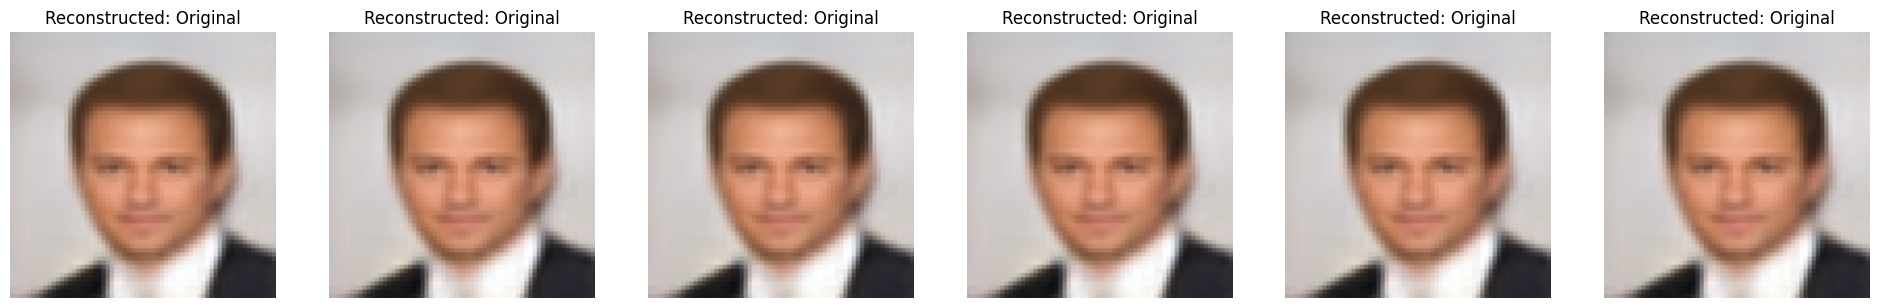

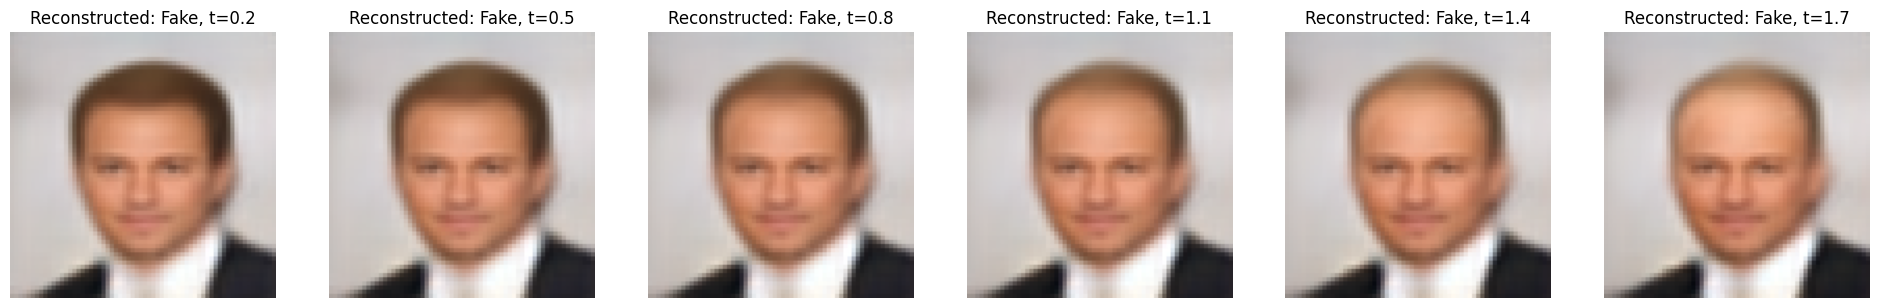

In [96]:
plot_multiple_images_tag(variational_decoder(original_imgs), len(ts), k=k, tag='Original')
plot_multiple_images_tag(variational_decoder(fake_imgs), len(ts), k=k, tag='Fake', ts=ts)


In [97]:

t = 0.8
fake_imgs = []
ts = [0.2, 0.5, 0.8, 1.1, 1.4, 1.7]
for t in ts:
    fake_imgs.append((O + t * v_att2))
fake_imgs = tf.convert_to_tensor(np.array(fake_imgs))

original_imgs = []
for t in ts:
    original_imgs.append((O + 0.00001 * v_att2))
original_imgs = tf.convert_to_tensor(np.array(original_imgs))

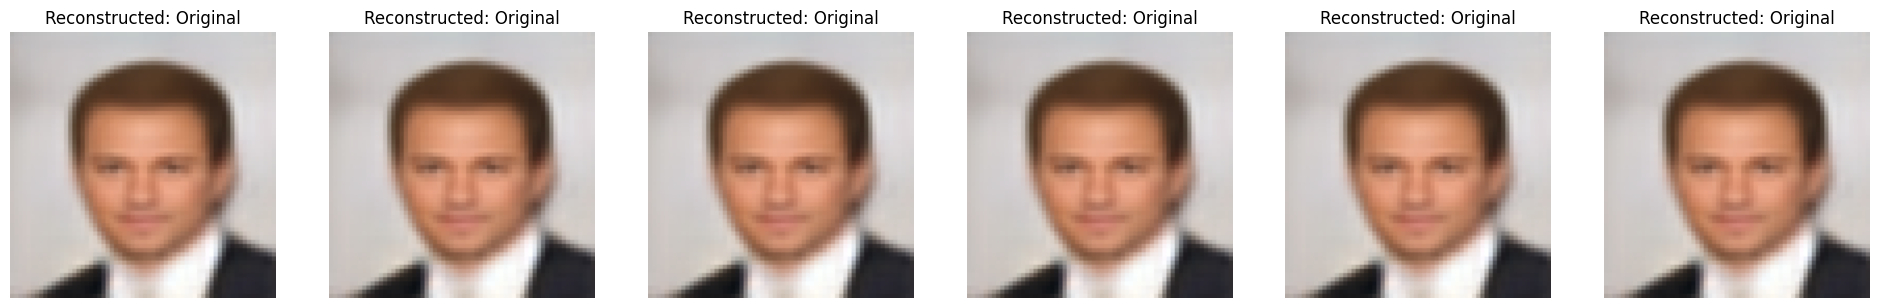

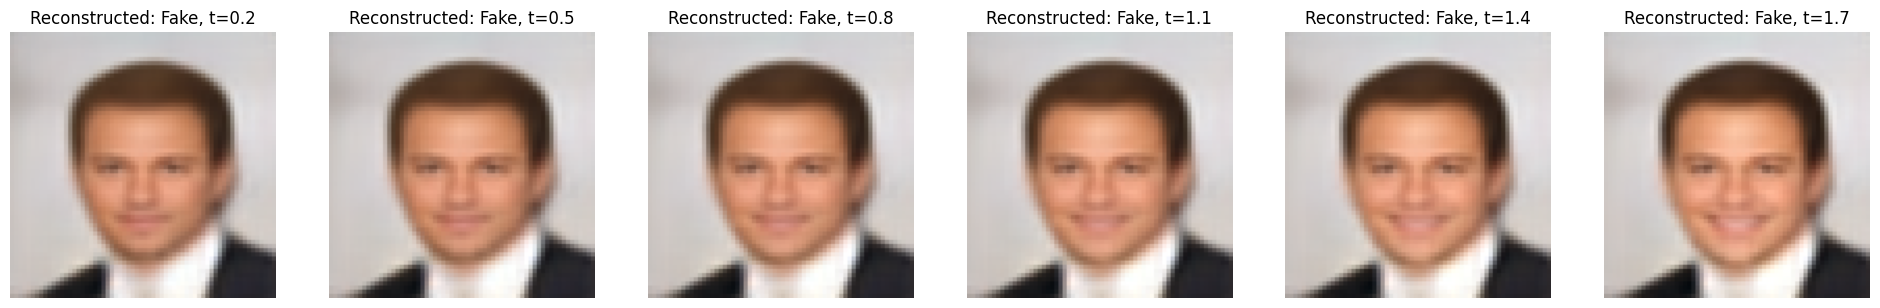

In [98]:
plot_multiple_images_tag(variational_decoder(original_imgs), len(ts), k=k, tag='Original')
plot_multiple_images_tag(variational_decoder(fake_imgs), len(ts), k=k, tag='Fake', ts=ts)

In [101]:
O + 0.00001 * v_att2

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([ 4.51462090e-01,  2.41734087e-01,  1.52164721e+00,  9.57130492e-01,
       -5.27791977e-01, -1.05379999e-01,  1.71688545e+00,  1.78022161e-01,
        1.04447275e-01,  1.46034169e+00,  9.47854340e-01, -7.51756907e-01,
       -1.23262286e-01, -1.27995133e+00,  1.40651360e-01, -3.28722924e-01,
       -6.44658446e-01, -2.23582983e+00,  1.01051044e+00,  1.20267165e+00,
       -5.19020915e-01,  3.15615922e-01,  1.99958897e+00,  1.28786671e+00,
       -2.51435768e-03,  2.59323001e-01, -3.16538304e-01, -1.56897402e+00,
        8.17393541e-01, -7.46619284e-01,  7.63177633e-01, -3.34150940e-01,
        6.91149831e-01,  1.03762579e+00,  1.67634320e+00, -1.29139268e+00,
       -1.15900064e+00,  1.05327451e+00,  2.28470802e+00,  2.48539734e+00,
        6.03473857e-02, -3.27705257e-02, -5.21880984e-02,  3.81605417e-01,
       -4.31657545e-02, -3.08795869e-01,  1.73025143e+00, -4.81168747e-01,
       -5.55042088e-01,  1.22748458e+00, -7.86814690e

In [107]:
original_imgs

<tf.Tensor: shape=(6, 64), dtype=float32, numpy=
array([[ 4.51462090e-01,  2.41734087e-01,  1.52164721e+00,
         9.57130492e-01, -5.27791977e-01, -1.05379999e-01,
         1.71688545e+00,  1.78022161e-01,  1.04447275e-01,
         1.46034169e+00,  9.47854340e-01, -7.51756907e-01,
        -1.23262286e-01, -1.27995133e+00,  1.40651360e-01,
        -3.28722924e-01, -6.44658446e-01, -2.23582983e+00,
         1.01051044e+00,  1.20267165e+00, -5.19020915e-01,
         3.15615922e-01,  1.99958897e+00,  1.28786671e+00,
        -2.51435768e-03,  2.59323001e-01, -3.16538304e-01,
        -1.56897402e+00,  8.17393541e-01, -7.46619284e-01,
         7.63177633e-01, -3.34150940e-01,  6.91149831e-01,
         1.03762579e+00,  1.67634320e+00, -1.29139268e+00,
        -1.15900064e+00,  1.05327451e+00,  2.28470802e+00,
         2.48539734e+00,  6.03473857e-02, -3.27705257e-02,
        -5.21880984e-02,  3.81605417e-01, -4.31657545e-02,
        -3.08795869e-01,  1.73025143e+00, -4.81168747e-01,
       

In [115]:
tf.reshape((O + 0.00001 * v_att2), (1, 64))

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[ 4.51462090e-01,  2.41734087e-01,  1.52164721e+00,
         9.57130492e-01, -5.27791977e-01, -1.05379999e-01,
         1.71688545e+00,  1.78022161e-01,  1.04447275e-01,
         1.46034169e+00,  9.47854340e-01, -7.51756907e-01,
        -1.23262286e-01, -1.27995133e+00,  1.40651360e-01,
        -3.28722924e-01, -6.44658446e-01, -2.23582983e+00,
         1.01051044e+00,  1.20267165e+00, -5.19020915e-01,
         3.15615922e-01,  1.99958897e+00,  1.28786671e+00,
        -2.51435768e-03,  2.59323001e-01, -3.16538304e-01,
        -1.56897402e+00,  8.17393541e-01, -7.46619284e-01,
         7.63177633e-01, -3.34150940e-01,  6.91149831e-01,
         1.03762579e+00,  1.67634320e+00, -1.29139268e+00,
        -1.15900064e+00,  1.05327451e+00,  2.28470802e+00,
         2.48539734e+00,  6.03473857e-02, -3.27705257e-02,
        -5.21880984e-02,  3.81605417e-01, -4.31657545e-02,
        -3.08795869e-01,  1.73025143e+00, -4.81168747e-01,
       

In [117]:
variational_decoder(tf.reshape((O + 0.00001 * v_att2), (1, 64)))[0]

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.7030414 , 0.70039684, 0.6974213 ],
        [0.7030414 , 0.70039684, 0.6974213 ],
        [0.7292956 , 0.7232267 , 0.7259185 ],
        ...,
        [0.81198007, 0.8012799 , 0.7950735 ],
        [0.7889609 , 0.78766906, 0.7845242 ],
        [0.7889609 , 0.78766906, 0.7845242 ]],

       [[0.7030414 , 0.70039684, 0.6974213 ],
        [0.7030414 , 0.70039684, 0.6974213 ],
        [0.7292956 , 0.7232267 , 0.7259185 ],
        ...,
        [0.81198007, 0.8012799 , 0.7950735 ],
        [0.7889609 , 0.78766906, 0.7845242 ],
        [0.7889609 , 0.78766906, 0.7845242 ]],

       [[0.7218382 , 0.7138103 , 0.7156359 ],
        [0.7218382 , 0.7138103 , 0.7156359 ],
        [0.740961  , 0.72931933, 0.73329926],
        ...,
        [0.8165013 , 0.80664515, 0.80333596],
        [0.81052655, 0.8033162 , 0.7980306 ],
        [0.81052655, 0.8033162 , 0.7980306 ]],

       ...,

       [[0.75841415, 0.7226278 , 0.70676273],
        [0.75

In [10]:
v_att1 = df_atts_loaded.values[0]
v_att2 = df_atts_loaded.values[1]
v_att3 = df_atts_loaded.values[2]
v_att4 = df_atts_loaded.values[3]
v_att5 = df_atts_loaded.values[4]
v_att6 = df_atts_loaded.values[5]
v_att7 = df_atts_loaded.values[6]

In [15]:
import gradio as gr
import os

maximum_ = 25
delta = 1.0 / maximum_
def image_classifier(value_1, value_2, value_3, value_4, value_5, value_6, value_7):
    return np.clip(((variational_decoder(tf.reshape((O + delta * value_1 * v_att1 + \
                                                     delta * 1.5 * value_2 * v_att2 + \
                                                     delta * 3.5 * value_3 * v_att3 + \
                                                     3.2 * delta * value_4 * v_att4 + \
                                                     4.0 * delta * value_5 * v_att5 + \
                                                     delta * value_6 * v_att6 + \
                                                     3.0 * delta * value_7 * v_att7), (1, 64)))[0]) * 255), 0, 255).astype(int)[:, :, :]

input_value_d_1 = gr.Slider(minimum=0, maximum=25, default=0, step=1)
input_value_d_2 = gr.Slider(minimum=0, maximum=25, default=0, step=1)
input_value_d_3 = gr.Slider(minimum=0, maximum=25, default=0, step=1)
input_value_d_4 = gr.Slider(minimum=0, maximum=25, default=0, step=1)
input_value_d_5 = gr.Slider(minimum=0, maximum=25, default=0, step=1)
input_value_d_6 = gr.Slider(minimum=0, maximum=25, default=0, step=1)
input_value_d_7 = gr.Slider(minimum=0, maximum=25, default=0, step=1)
demo = gr.Interface(fn=image_classifier, inputs=[input_value_d_1, 
                                                 input_value_d_2, 
                                                 input_value_d_3, 
                                                 input_value_d_4, 
                                                 input_value_d_5,
                                                 input_value_d_6,
                                                 input_value_d_7], outputs="image", live=True)

if __name__ == "__main__":
    demo.launch(server_port=501, debug=True, server_name='localhost')

C:\Users\gabri\AppData\Local\Temp\ipykernel_23744\2917828640.py:15: GradioUnusedKwargWarning: You have unused kwarg parameters in Slider, please remove them: {'default': 0}
  input_value_d_1 = gr.Slider(minimum=0, maximum=25, default=0, step=1)
C:\Users\gabri\AppData\Local\Temp\ipykernel_23744\2917828640.py:16: GradioUnusedKwargWarning: You have unused kwarg parameters in Slider, please remove them: {'default': 0}
  input_value_d_2 = gr.Slider(minimum=0, maximum=25, default=0, step=1)
C:\Users\gabri\AppData\Local\Temp\ipykernel_23744\2917828640.py:17: GradioUnusedKwargWarning: You have unused kwarg parameters in Slider, please remove them: {'default': 0}
  input_value_d_3 = gr.Slider(minimum=0, maximum=25, default=0, step=1)
C:\Users\gabri\AppData\Local\Temp\ipykernel_23744\2917828640.py:18: GradioUnusedKwargWarning: You have unused kwarg parameters in Slider, please remove them: {'default': 0}
  input_value_d_4 = gr.Slider(minimum=0, maximum=25, default=0, step=1)
C:\Users\gabri\AppDa

Running on local URL:  http://localhost:501

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
